In [1]:
import warnings
warnings.simplefilter("ignore")

import numpy as np
import numpy.linalg as LA
from scipy import optimize
from maxvolpy.maxvol import rect_maxvol, maxvol
import matplotlib.pyplot as plt
from mva_test import test_points_gen
from scipy.spatial import distance_matrix

from mva_test import *
import gen_mat as gen
import grad_log_det as log_det # this is a module with analytical calculation of gradient and objective 

%matplotlib inline

In [2]:
dim = 2

col = 60
n_pnts = 150

def OptPoints(num_col=col, num_points=n_pnts, num_tries=1, interval=(-1.0,1.0), poly=gen.cheb, useLHS=True, ToPlot=True):
    log_det.num_col = num_col # this is a global variable in module log_det
    log_det.dim = dim  
    bnds = (interval,) * (dim*num_points)
    dstrs = ['random']
    if useLHS:
        dstrs.append('LHS')
        
    loss_f = lambda x: log_det.loss_func(x, poly=poly, ToGenDiff=False)
    loss_grad = lambda x: log_det.grad(x, poly=poly)
    res = np.inf
    for distrib in dstrs:
        for _ in range(num_tries):
            x_0 = test_points_gen(num_points, dim, interval=interval, distrib=distrib) # starting point of GD
            x_0 = x_0.ravel('F')
            op = optimize.fmin_l_bfgs_b(loss_f, x_0, fprime = loss_grad, factr = 10.0, bounds = bnds)
            res_cur = op[1]
            if res_cur < res:
                res = res_cur
                pnts = op[0]
                opt_distr = distrib
            
    pnts = pnts.reshape(pnts.size//dim, dim, order="F")
    if ToPlot:
        ax = plt.figure(figsize=(7,7)).add_subplot(111)
        ax.plot(pnts[:,0], pnts[:,1], 'ro', label = "GD")
        ax.set_aspect(1)
                
    return res, pnts, opt_distr

CPU times: user 1min 8s, sys: 2.95 s, total: 1min 11s
Wall time: 16.6 s


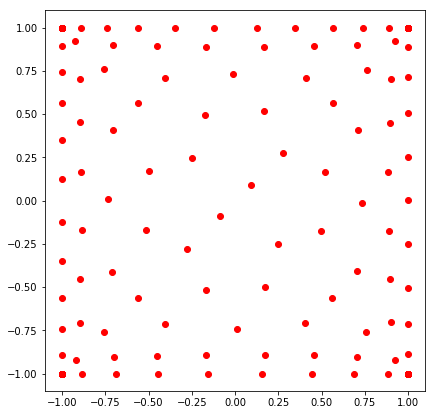

In [12]:
np.random.seed(3)

%time _, pnts, __ = OptPoints(num_tries=2, useLHS=True)
# plt.scatter(pnts[:,0],pnts[:,1], c='r')
plt.show()

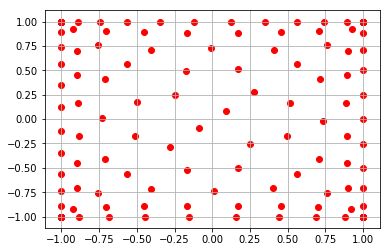

In [13]:
plt.scatter(pnts[:,0],pnts[:,1], c='r')

plt.grid()
plt.show()

In [14]:
D = distance_matrix(pnts,pnts)
D[D==0.] = None
H = [np.nanmin(D[i]) for i in range(len(D))] 
print(min(H),np.argmin(H))

0.08268503239714298 47


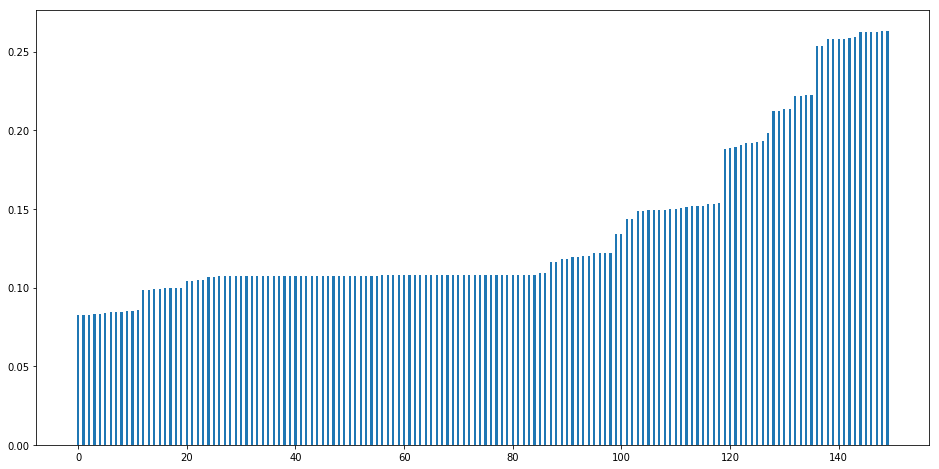

In [15]:
plt.figure(figsize=(16,8))
plt.bar(range(len(D))[:],np.sort(H)[:], width=0.4)
#plt.savefig('/Users/vitaly/Desktop/oversampling_distances_60_terms_150_points_.png')
plt.show()

In [16]:
np.random.seed(3)
mv_points = test_points_gen(int(2e6), dim, distrib='LHS',interval=(-1.0,1.0))

#MaxVol
M = gen.GenMat(col, mv_points, poly = gen.cheb, ToGenDiff=False) 
%time row_indx,_ = rect_maxvol(M, tol = 1.01, minK = n_pnts, maxK = n_pnts)
pnts_mv = np.array(list(map(lambda x,y: [x,y], M[row_indx][:,1],M[row_indx][:,2])))
#pnts = reshape(pnts,(pnts.size,1))

CPU times: user 2min 21s, sys: 2.82 s, total: 2min 24s
Wall time: 41.6 s


In [17]:
D_mv = distance_matrix(pnts_mv,pnts_mv)
D_mv[D_mv==0.] = None
H_mv = [np.nanmin(D_mv[i]) for i in range(len(D_mv))] 
print(min(H_mv),np.argmin(H_mv))

0.0011118016775819345 3


In [9]:
# D_min = distance_matrix(mv_points,mv_points)
# D_min[D_min==0.] = None
# H_min = [np.nanmin(D_min[i]) for i in range(len(D_min))] 
# print(min(H_min),np.argmin(H_min))

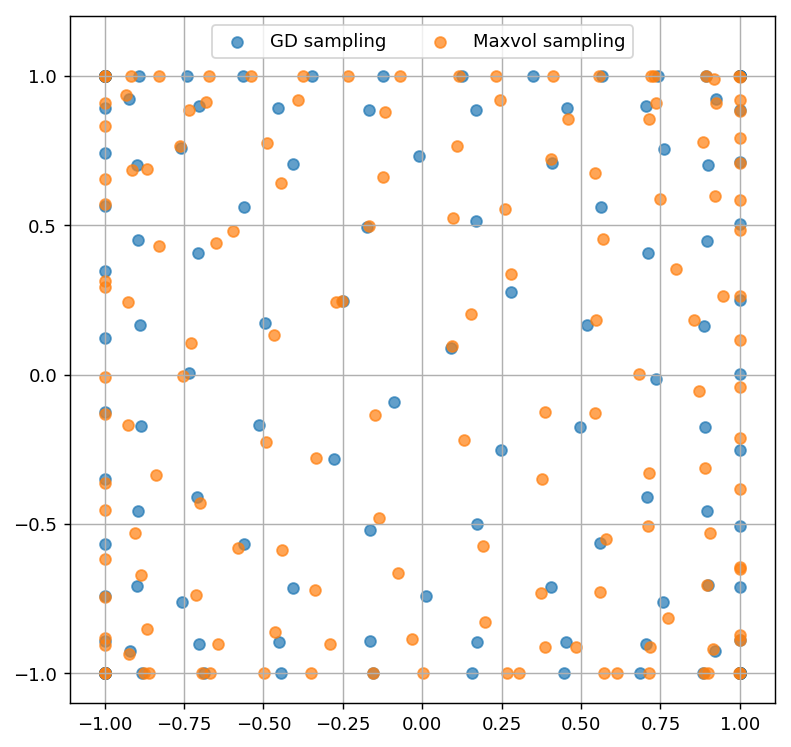

In [10]:
plt.figure(figsize=(7,7), dpi=130)
plt.scatter(pnts[:,0],pnts[:,1], alpha=0.7, label = 'GD sampling')
plt.scatter(pnts_mv[:,0],pnts_mv[:,1], alpha=0.7, label = 'Maxvol sampling')
plt.legend(loc=9,ncol=2)
plt.ylim(-1.1,1.2)
plt.grid()
#plt.savefig('/Users/vitaly/Downloads/oversampling_60_terms_'+str(n_pnts)+'_points_distribution.png')
plt.show()

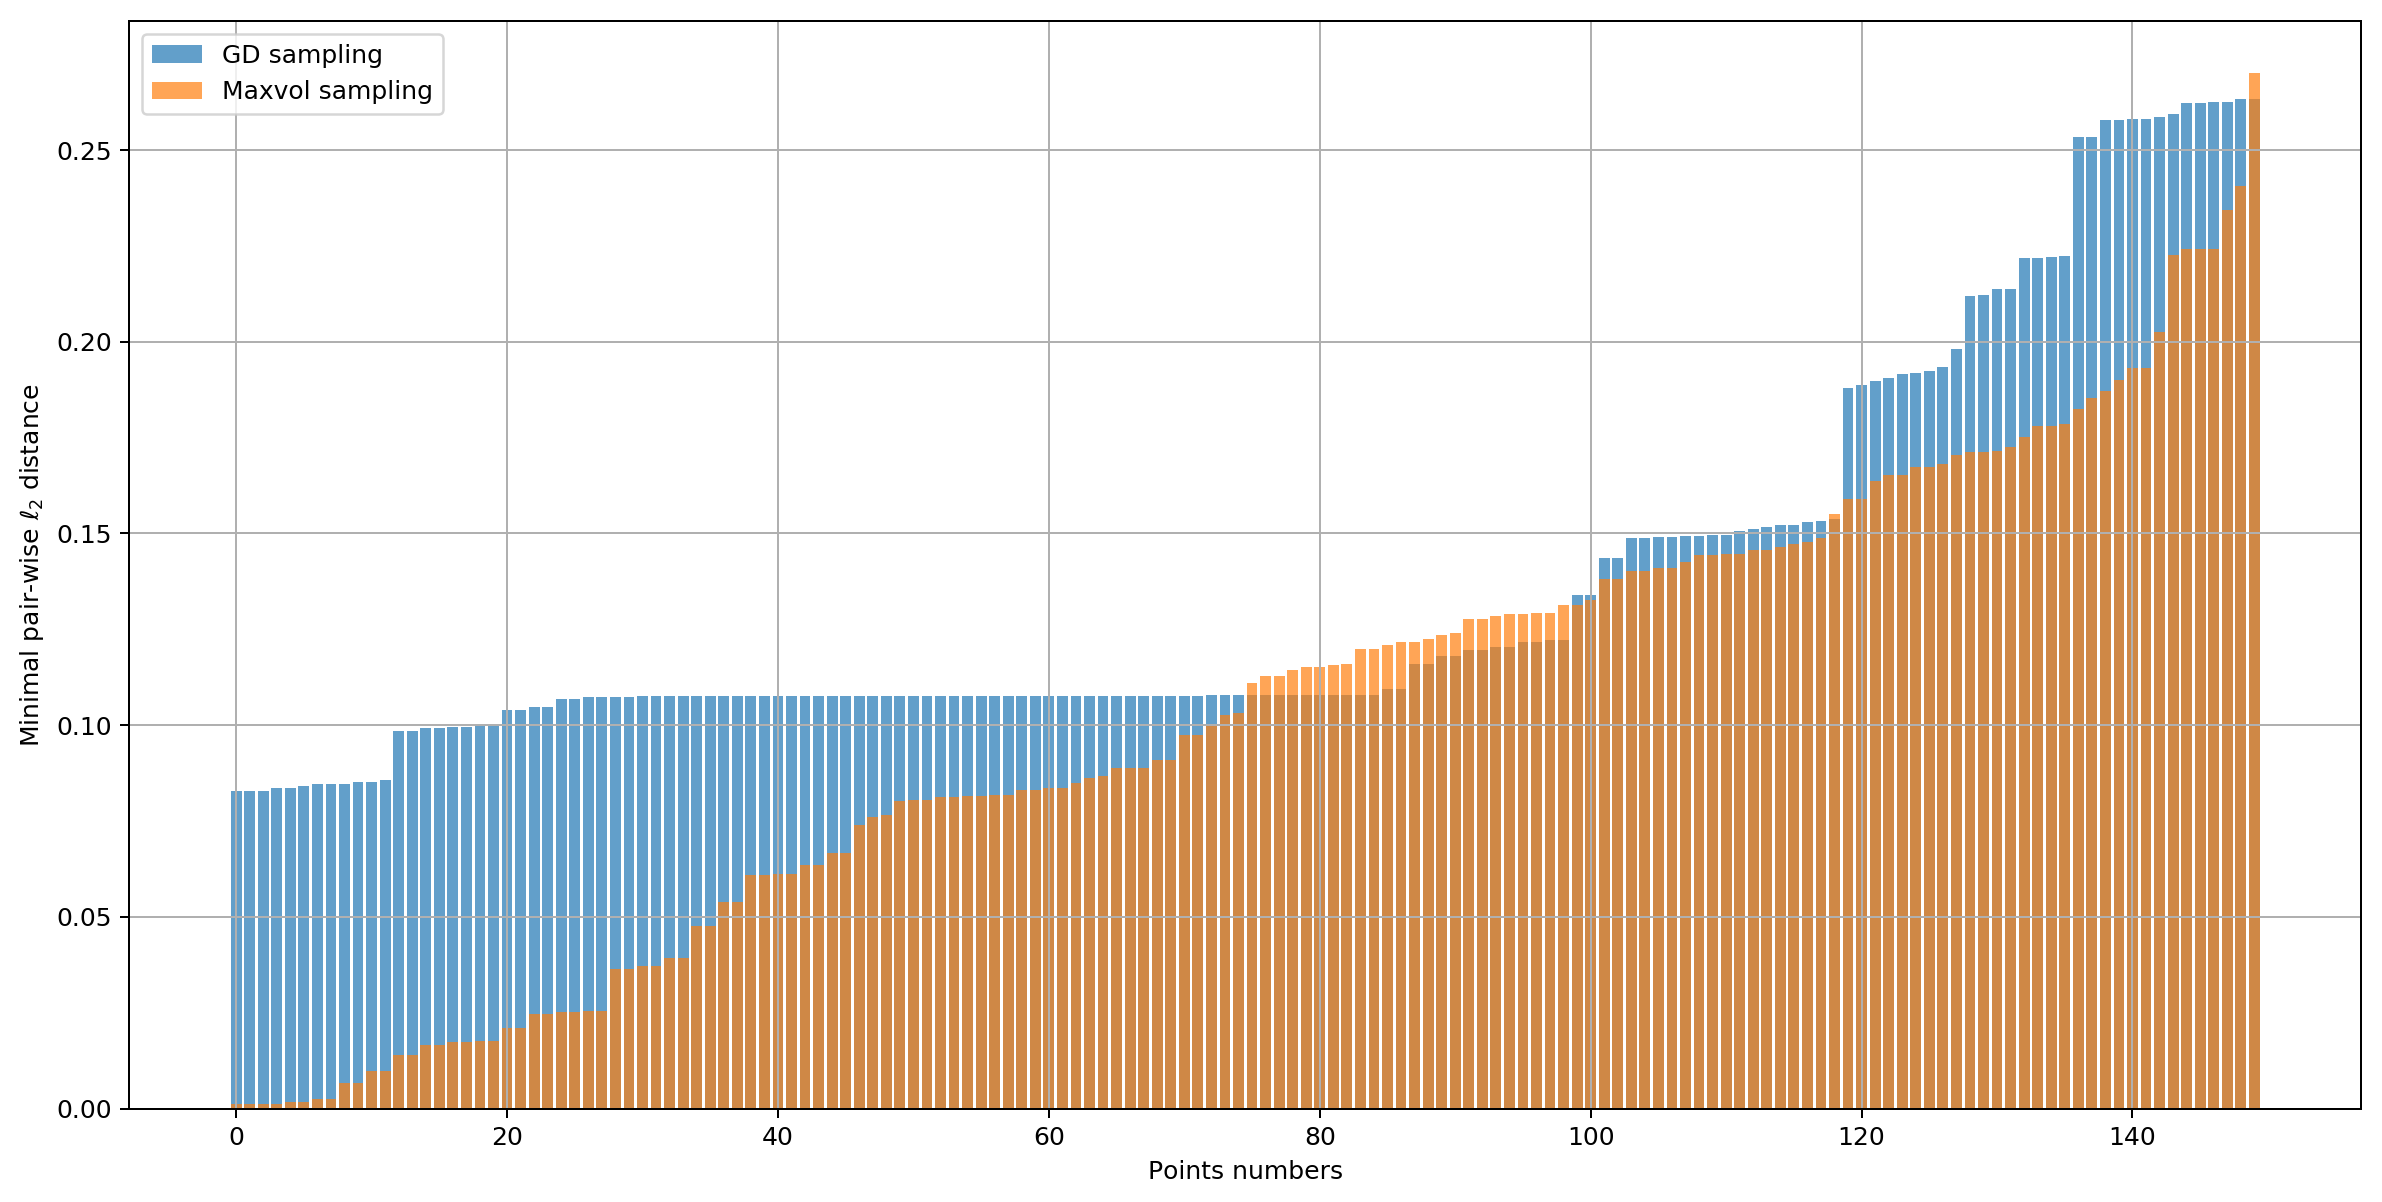

In [11]:
plt.figure(figsize=(16,8), dpi=180)
plt.bar(range(len(D))[:],np.sort(H)[:], width=0.8, alpha=0.7, label = 'GD sampling')
plt.bar(range(len(D_mv))[:],np.sort(H_mv)[:], width=0.8, alpha=0.7, label = 'Maxvol sampling')
plt.xlabel('Points numbers')
plt.ylabel('Minimal pair-wise $\ell_2$ distance')
plt.legend()
plt.grid()
#plt.savefig('/Users/vitaly/Downloads/oversampling_60_terms_'+str(n_pnts)+'_points.png')
plt.show()